## Create Custom Handler for Inference Endpoints


In [7]:
!pip install diffusers --upgrade

  Using cached diffusers-0.10.2-py3-none-any.whl (503 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.9.0
    Uninstalling diffusers-0.9.0:
      Successfully uninstalled diffusers-0.9.0


In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


if device.type != 'cuda':
    raise ValueError("need to run on GPU")

In [4]:
%%writefile handler.py
from typing import  Dict, List, Any
import torch
from diffusers import DPMSolverMultistepScheduler, StableDiffusionInpaintPipeline
from PIL import Image
import base64
from io import BytesIO


# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type != 'cuda':
    raise ValueError("need to run on GPU")

class EndpointHandler():
    def __init__(self, path=""):
        # load StableDiffusionInpaintPipeline pipeline
        self.pipe = StableDiffusionInpaintPipeline.from_pretrained(path, torch_dtype=torch.float16)
        # use DPMSolverMultistepScheduler
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        # move to device        
        self.pipe = self.pipe.to(device)


    def __call__(self, data: Any) -> List[List[Dict[str, float]]]:
        """
        :param data: A dictionary contains `inputs` and optional `image` field.
        :return: A dictionary with `image` field contains image in base64.
        """
        inputs = data.pop("inputs", data)
        encoded_image = data.pop("image", None)
        encoded_mask_image = data.pop("mask_image", None)
        
        # hyperparamters
        num_inference_steps = data.pop("num_inference_steps", 25)
        guidance_scale = data.pop("guidance_scale", 7.5)
        negative_prompt = data.pop("negative_prompt", None)
        height = data.pop("height", None)
        width = data.pop("width", None)
        
        # process image
        if encoded_image is not None and encoded_mask_image is not None:
            image = self.decode_base64_image(encoded_image)
            mask_image = self.decode_base64_image(encoded_mask_image)
        else:
            image = None
            mask_image = None 
        
        # run inference pipeline
        out = self.pipe(inputs, 
                        image=image,             
                        mask_image=mask_image,             
                        num_inference_steps=num_inference_steps,
                        guidance_scale=guidance_scale,
                        num_images_per_prompt=1,
                        negative_prompt=negative_prompt,
                        height=height,
                        width=width
        )
            
        # return first generate PIL image
        return out.images[0]
    
    # helper to decode input image
    def decode_base64_image(self, image_string):
        base64_image = base64.b64decode(image_string)
        buffer = BytesIO(base64_image)
        image = Image.open(buffer)
        return image

Overwriting handler.py


In [1]:
from handler import EndpointHandler

# init handler
my_handler = EndpointHandler(path=".")

In [30]:
import base64
from PIL import Image
from io import BytesIO

# helper image utils
def encode_image(image_path):
  with open(image_path, "rb") as i:
    b64 = base64.b64encode(i.read())
  return b64.decode("utf-8")

prompt = "Face of a bengal cat, high resolution, sitting on a park bench"
image = encode_image("dog.png")
mask_image = encode_image("mask_dog.png")

# prepare sample payload
request = {"inputs": prompt, "image": image, "mask_image": mask_image}

# test the handler
pred = my_handler(request)

  0%|          | 0/25 [00:00<?, ?it/s]

In [33]:
image

'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAABGdBTUEAALGPC/xhBQAAACBjSFJNAAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAABmJLR0QA/wD/AP+gvaeTAAAAB3RJTUUH5QwUDyQ6rG5ycQAAgABJREFUeNrs/dF2JDmuLQhuAKS5FJHnnp7uteb/H+Yj5nW+pnutvn3PqcoMhdxIYM8DSDNzl0shKRSZkVXBysqU5O7mZjQaCGxsbMj/5//7/7s/3f+//sd/fD7dOX31fu6rwkisqyNiqRYSQUYQxLKUWquKnkrVorUWegQIVbq7k2DvHYQVW9u6LPVUF1UFsJRaREUkBEIUVYiQBEElFCYKUkTy/QBERETwlkHyTe//NX6NX+PnHO94lvePUH/ct/wk4+rMX2Mqrz5SRKCqIioiAgkGydVXoYaHqgYDAg9vrZuo6LDmBEXEI4RU0wCCDDAiPIIkHQDCg3WcHEkKQAYohDPNP0giaBAKAQpkO8u3Wv9f49f4NX4NAJB4/R7wbztKUTNRIZhjvtC9B2lQUQlhhLt3tUoPVKSTrqpkqCoBRkSEO8kgGREiEBErRQCSAgEAEiIqGvQermaMIKkQhkDS4guI+fO3x993A/81fo1f44WRFuBND/jBaHAYnn/dcTU/x4k6Gk+ST21p/kVVCyO894igzDkTWDE106KlFkb03t29eeve3R3Do8fcBhgkcttI9590j+38IiKwbzAkPeiMYHj+AzrYGe7h42jcBo6//DL33zf+8hn8q7//1/g3GQIBJP7q0/hrxtWucPOhI1nSSTdVkh5BpuduKloUtVZVEPTw3jumITZVUxUVMzVRZwAEJCJUdXrw0IR9SFXLICNDgCDJAITB3DAAQAEiAKMIJDetDB2IXybjzSPvO65gtLkDQwD8KztHv8avMcYvLOgWlp5Wt5hJrbWUAiASn9FCQqG1FgWadxE

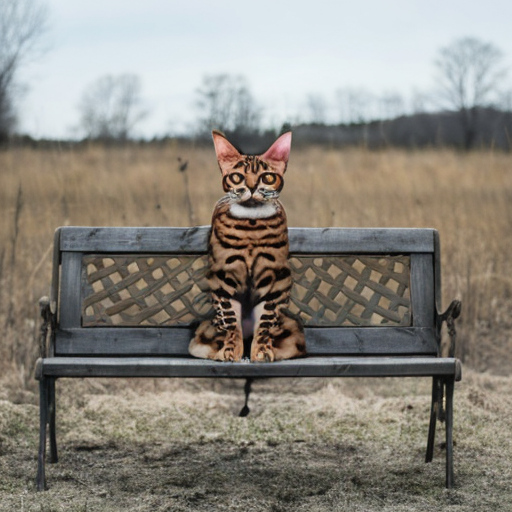

In [31]:
pred

In [32]:
pred.save("result.png")